# Computational Intelligence - Homework 3
## Mohammad Bahrami 972133 - Ghanbar Timar 9724853

In [23]:
!pip install -q torchinfo
!pip install -q wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import typing
import torchinfo
from tqdm.autonotebook import tqdm
import wandb
from IPython import display
import os
os.environ["WANDB_SILENT"] = "true"

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/CI_HW3
wandb.login()

Mounted at /content/gdrive
/content/gdrive/MyDrive/CI_HW3


<IPython.core.display.Javascript object>

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


True

## Part 1

### Default Config

In [3]:
class Config:
    OutputFile = 'Log.txt'
    Device = 'cuda' if torch.cuda.is_available() else 'cpu'
    LearningRate = 0.0001
    BatchSize = 128
    Epochs = 30
    

    ConvDims = (64, 128, 256)
    ConvKernelSizes = 3
    PoolKernelSizes = 2
    FCDims = (256,)
    ConvDropout = 0.25
    FCDropout = 0.5


    @staticmethod
    def _get_dict():
        return {key: value for key, value in Config.__dict__.items() if not key.startswith('_')}

### Data Preparation

In [4]:
dataset_train = datasets.FashionMNIST(root='.', download=False, train=True, transform=transforms.ToTensor())
dataset_test = datasets.FashionMNIST(root='.', download=False, train=False, transform=transforms.ToTensor())
dataset_eval, dataset_test = torch.utils.data.random_split(
    dataset=dataset_test,
    lengths=[
        round(len(dataset_test)*0.5),
        round(len(dataset_test)*0.5)
    ],
    generator=torch.Generator().manual_seed(9724133)
)


label_decode = pd.Series({
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
})
image_size = dataset_train[0][0].shape

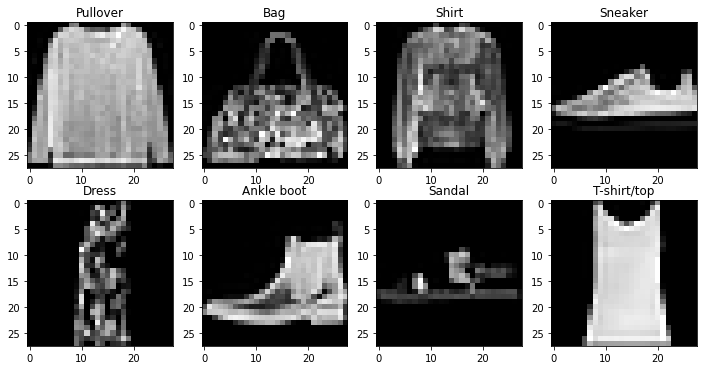

In [5]:
# Showing 5 Random samples
n = 8
size = 3
indcs = np.random.randint(0, len(dataset_train), size=(n,))
fig, axs = plt.subplots(nrows=n//4, ncols=4, squeeze=False, figsize=(size*4, size*n//4))
for i in range(n):
    axs[i//4][i%4].imshow(dataset_train[indcs[i]][0].squeeze(), cmap='gray')
    axs[i//4][i%4].set_title(label_decode[dataset_train[indcs[i]][1]])

### Model Definition

In [6]:
class TimiFashion(nn.Module):
    def __init__(
        self,
        input_shape: typing.Tuple[int], #(num_chnnels, width, height)
        num_classes: int,
        conv_dims: typing.Iterable[int],
        conv_kernel_sizes: int,
        pool_kernel_sizes: int,
        fc_dims: typing.Iterable[int],
        dropouts: typing.Dict[str, float]
        ):
        super().__init__()

        self.dropouts = dropouts

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=input_shape[0],
                    out_channels=conv_dims[0],
                    kernel_size=conv_kernel_sizes,
                    padding='same'
                )
            ] + [
                nn.Conv2d(
                    in_channels=conv_dims[i],
                    out_channels=conv_dims[i+1],
                    kernel_size=conv_kernel_sizes,
                    padding='same'
                )
                for i in range(len(conv_dims) - 1)
            ]
        )

        self.pools = nn.ModuleList([
            nn.MaxPool2d(
                kernel_size=pool_kernel_sizes,
                # padding='same'
            )
            for i in range(len(conv_dims))
        ])

        self.batchnorms = nn.ModuleList([
            nn.BatchNorm2d(
                num_features=conv_dims[i],
            )
            for i in range(len(conv_dims))
        ])

        self.fcs = nn.ModuleList(
            [
                nn.Linear(
                    in_features=conv_dims[-1] * (input_shape[1] // pool_kernel_sizes**len(conv_dims)) * (input_shape[2] // pool_kernel_sizes**len(conv_dims)),
                    out_features=fc_dims[0]
                )
            ] + [
                nn.Linear(
                    in_features=fc_dims[i],
                    out_features=fc_dims[i+1]
                )
                for i in range(len(fc_dims) - 1)
            ] + [
                nn.Linear(
                    in_features=fc_dims[-1],
                    out_features=num_classes
                )
            ]
        )

    def forward(self, x): #(batch_size, 28, 28, 1)
        for i in range(len(self.convs)):
            x = self.convs[i](x)
            x = self.batchnorms[i](x)
            x = F.relu(x)
            x = self.pools[i](x)
            x = F.dropout(x, p=self.dropouts['conv'], training=self.training)

        x = torch.reshape(x, shape=(x.shape[0], -1))

        for i in range(len(self.fcs) - 1):
            x = self.fcs[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropouts['fc'], training=self.training)
        x = self.fcs[-1](x)
        # x.shape: (batch_size, num_class)
        return F.softmax(x, dim=1)


### Train / Test Loop

In [7]:
def train(
    model: nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer
):
    model.train()
    optimizer.zero_grad()
    out = model(X)
    loss = criterion(out, Y)
    loss.backward()
    optimizer.step()

    prediction = torch.argmax(out, dim=1)
    correct = (prediction == Y).sum()
    total = Y.shape[0]
    return loss.item(), correct.item(), total


@torch.no_grad()
def evaluation(
    model: nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor
):
    model.eval()
    out = model(X)
    prediction = torch.argmax(out, dim=1)
    correct = (prediction == Y).sum()
    total = Y.shape[0]
    model.train()
    return correct.item(), total

### Fit and Plot Functions

In [8]:
def fit(config: dict=None, summary: bool=False, nested_tqdm: bool=False, use_wandb: bool=True):
    if config is None:
        config=Config._get_dict()

    if use_wandb:
        wandb.init(
            project="CI_HW3",
            entity="indirected-team",
            config=config
        )

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=config['BatchSize'], shuffle=True)
    eval_loader = torch.utils.data.DataLoader(dataset_eval, batch_size=config['BatchSize']*2, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=config['BatchSize']*2, shuffle=False)

    model = TimiFashion(
        input_shape=image_size,
        num_classes=label_decode.shape[0],
        conv_dims=config['ConvDims'],
        conv_kernel_sizes=config['ConvKernelSizes'],
        pool_kernel_sizes=config['PoolKernelSizes'],
        fc_dims=config['FCDims'],
        dropouts={'conv': config['ConvDropout'], 'fc': config['FCDropout']}
    ).to(config['Device'])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['LearningRate'])

    with open(config['OutputFile'], 'w') as fp:
        fp.write('')

    if summary:
        print(torchinfo.summary(
            model,
            input_size=(config['BatchSize'], image_size[0], image_size[1], image_size[2]),
            col_names=[
                "input_size",
                "output_size",
                "num_params",
            ]
        ))

    try:
        loss_list = []
        train_acc_list = []
        eval_acc_list = []
        for epoch in tqdm(range(config['Epochs'])):
            train_epoch_loss = 0
            train_epoch_correct = 0
            train_epoch_total = 0
            gen = tqdm(train_loader, leave=False, desc='Train') if nested_tqdm else train_loader

            for batch_x, batch_y in gen:
                batch_x = batch_x.to(config['Device'])
                batch_y = batch_y.to(config['Device'])
                
                train_loss, train_correct, train_total = train(model, batch_x, batch_y, criterion, optimizer)

                train_epoch_loss += train_loss
                train_epoch_correct += train_correct
                train_epoch_total += train_total

            eval_epoch_correct = 0
            eval_epoch_total = 0
            gen = tqdm(eval_loader, leave=False, desc='Validation') if nested_tqdm else eval_loader
            for batch_x, batch_y in gen:
                batch_x = batch_x.to(config['Device'])
                batch_y = batch_y.to(config['Device'])
                eval_correct, eval_total = evaluation(model, batch_x, batch_y)

                eval_epoch_correct += eval_correct
                eval_epoch_total += eval_total

            train_epoch_loss = train_epoch_loss / len(train_loader)
            train_epoch_accuracy = train_epoch_correct / train_epoch_total
            eval_epoch_accuracy = eval_epoch_correct / eval_epoch_total

            loss_list.append(train_epoch_loss)
            train_acc_list.append(train_epoch_accuracy)
            eval_acc_list.append(eval_epoch_accuracy)
            
            if use_wandb:
                wandb.log({
                    'loss': train_epoch_loss,
                    'train accuracy': train_epoch_accuracy,
                    'validation accuracy': eval_epoch_accuracy
                })
            
            with open(config['OutputFile'], 'a') as fp:
                fp.write(f'Epoch: {epoch + 1} - Loss: {train_epoch_loss:.6f} - Train Accuracy: {train_epoch_accuracy*100:.2f} - Validation Accuracy: {eval_epoch_accuracy*100:.2f}\n')
            # print(f'Epoch: {epoch + 1} - Loss: {train_epoch_loss:.6f} - Train Accuracy: {train_epoch_accuracy*100:.2f} - Validation Accuracy: {eval_epoch_accuracy*100:.2f}')
    except KeyboardInterrupt:
        pass


    test_correct = 0
    test_total = 0
    for batch_x, batch_y in tqdm(test_loader, desc='Test'):
        batch_x = batch_x.to(config['Device'])
        batch_y = batch_y.to(config['Device'])
        correct, total = evaluation(model, batch_x, batch_y)

        test_correct += correct
        test_total += total

    test_accuracy = test_correct / test_total
    with open(config['OutputFile'], 'a') as fp:
        fp.write(f'Test Accuracy: {test_accuracy*100:.2f}\n')
    # print(f'Test Accuracy: {test_accuracy*100:.2f}')
    if use_wandb:
        wandb.log({'test accuracy': test_accuracy})
        wandb.finish()
    return loss_list, train_acc_list, eval_acc_list, test_accuracy

In [9]:
def plots(loss_list, train_acc_list, eval_acc_list, figsize: tuple=(18, 5), saveto: str=None):
    fig, axs = plt.subplots(1, 2, squeeze=False, figsize=figsize)
    axs[0, 0].plot(
        loss_list,
        label='Train Loss'
    )
    axs[0, 0].set_title('Loss Over Epochs')
    axs[0, 0].legend()
    
    axs[0, 1].plot(
        train_acc_list,
        label='Train Accuracy'
    )
    axs[0, 1].plot(
        eval_acc_list,
        label='Validation Accuracy'
    )
    axs[0, 1].legend()
    axs[0, 1].set_title('Accuracy Over Epochs')

    if saveto is not None:
        fig.savefig(saveto, bbox_inches='tight')

### Part 1.1

#### Default Parameters Run

In [ ]:
loss_list, train_acc_list, eval_acc_list, test_accuracy = fit(use_wandb=True, summary=True)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TimiFashion                              --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
├─ModuleList: 1-2                        --                        --                        --
├─ModuleList: 1-3                        --                        --                        --
├─ModuleList: 1-4                        --                        --                        --
├─ModuleList: 1-1                        --                        --                        --
│    └─Conv2d: 2-1                       [128, 1, 28, 28]          [128, 64, 28, 28]         640
├─ModuleList: 1-3                        --                        --                        --
│    └─BatchNorm2d: 2-2                  [128, 64, 28, 28]         [128, 64, 28, 28]         128
├─ModuleList: 1-2                

  0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 91.78


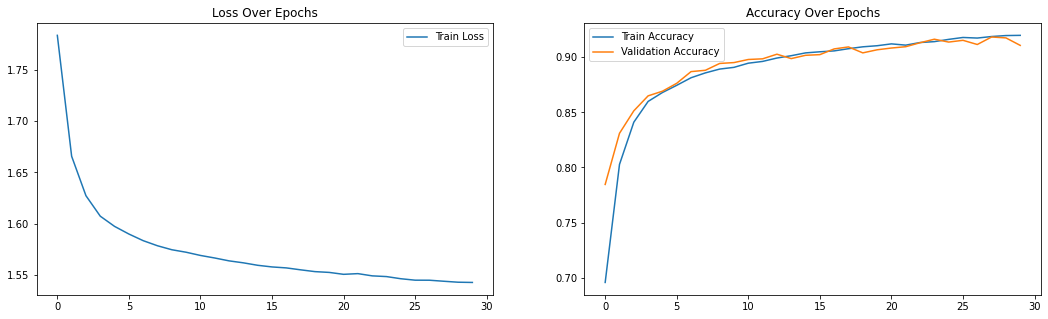

In [ ]:
print(f'Test Accuracy: {test_accuracy*100:.2f}')
plots(loss_list, train_acc_list, eval_acc_list)

#### Underfit Run

In [ ]:
config = Config._get_dict()
config['ConvDims'] = (2,)
config['ConvKernelSizes'] = 20
config['PoolKernelSizes'] = 2
config['FCDims'] = (2,)
config['Dropouts'] = {'conv': 0.6, 'fc': 0.8}
print(pd.Series(config))
loss_list, train_acc_list, eval_acc_list, test_accuracy = fit(config=config, use_wandb=True)

OutputFile                          Log.txt
Device                                 cuda
LearningRate                         0.0001
BatchSize                               128
Epochs                                   30
ConvDims                               (2,)
ConvKernelSizes                          20
PoolKernelSizes                           2
FCDims                                 (2,)
ConvDropout                            0.25
FCDropout                               0.5
Dropouts           {'conv': 0.6, 'fc': 0.8}
dtype: object


  0%|          | 0/30 [00:00<?, ?it/s]

/home/indirected/VirtualEnvs/torch-cuda102/lib/python3.10/site-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv2d(input, weight, bias, self.stride,


Test:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 47.18


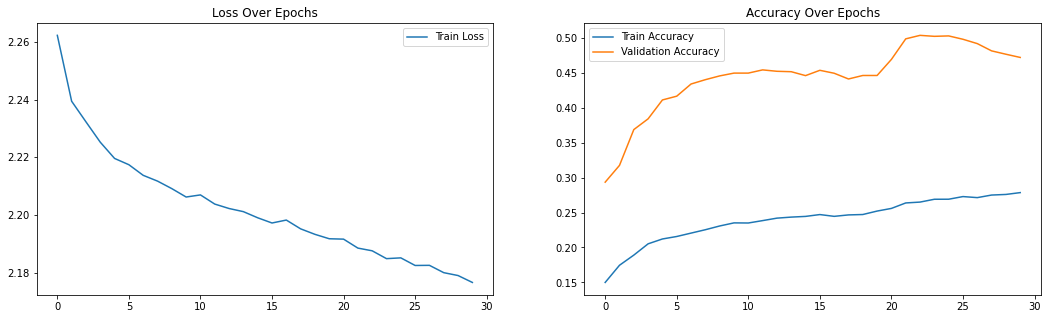

In [ ]:
print(f'Test Accuracy: {test_accuracy*100:.2f}')
plots(loss_list, train_acc_list, eval_acc_list)

#### Overfit Run

In [ ]:
config = Config._get_dict()
config['LearningRate'] = 0.00005
config['ConvDims'] = (64, 128, 512, 1024)
config['ConvKernelSizes'] = 3
config['PoolKernelSizes'] = 2
config['FCDims'] = (2048, 1024, 1024, 512)
config['Dropouts'] = {'conv': 0.0001, 'fc': 0.00001}
print(pd.Series(config))
loss_list, train_acc_list, eval_acc_list, test_accuracy = fit(config=config, use_wandb=True)

OutputFile                          Log.txt
Device                                 cuda
LearningRate                        0.00005
BatchSize                               256
Epochs                                   30
ConvDims                     (64, 128, 512)
ConvKernelSizes                   (5, 5, 5)
PoolKernelSizes                   (2, 2, 2)
FCDims              (2048, 1024, 1024, 512)
Dropouts           {'conv': 0.0, 'fc': 0.0}
dtype: object


  0%|          | 0/30 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy: 90.56


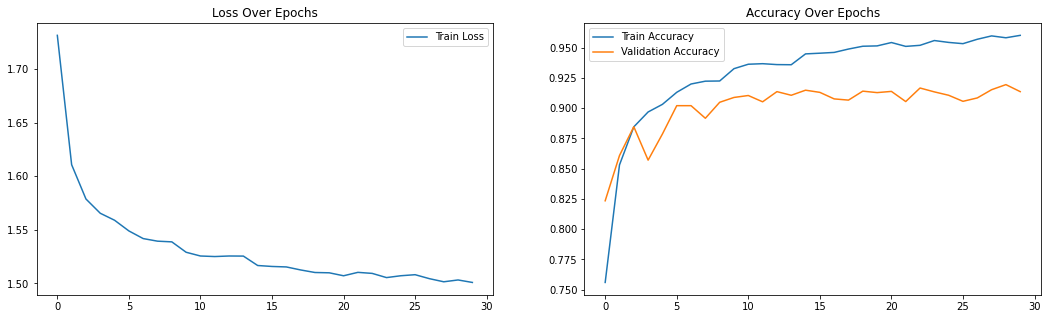

In [ ]:
print(f'Test Accuracy: {test_accuracy*100:.2f}')
plots(loss_list, train_acc_list, eval_acc_list)

#### Summary


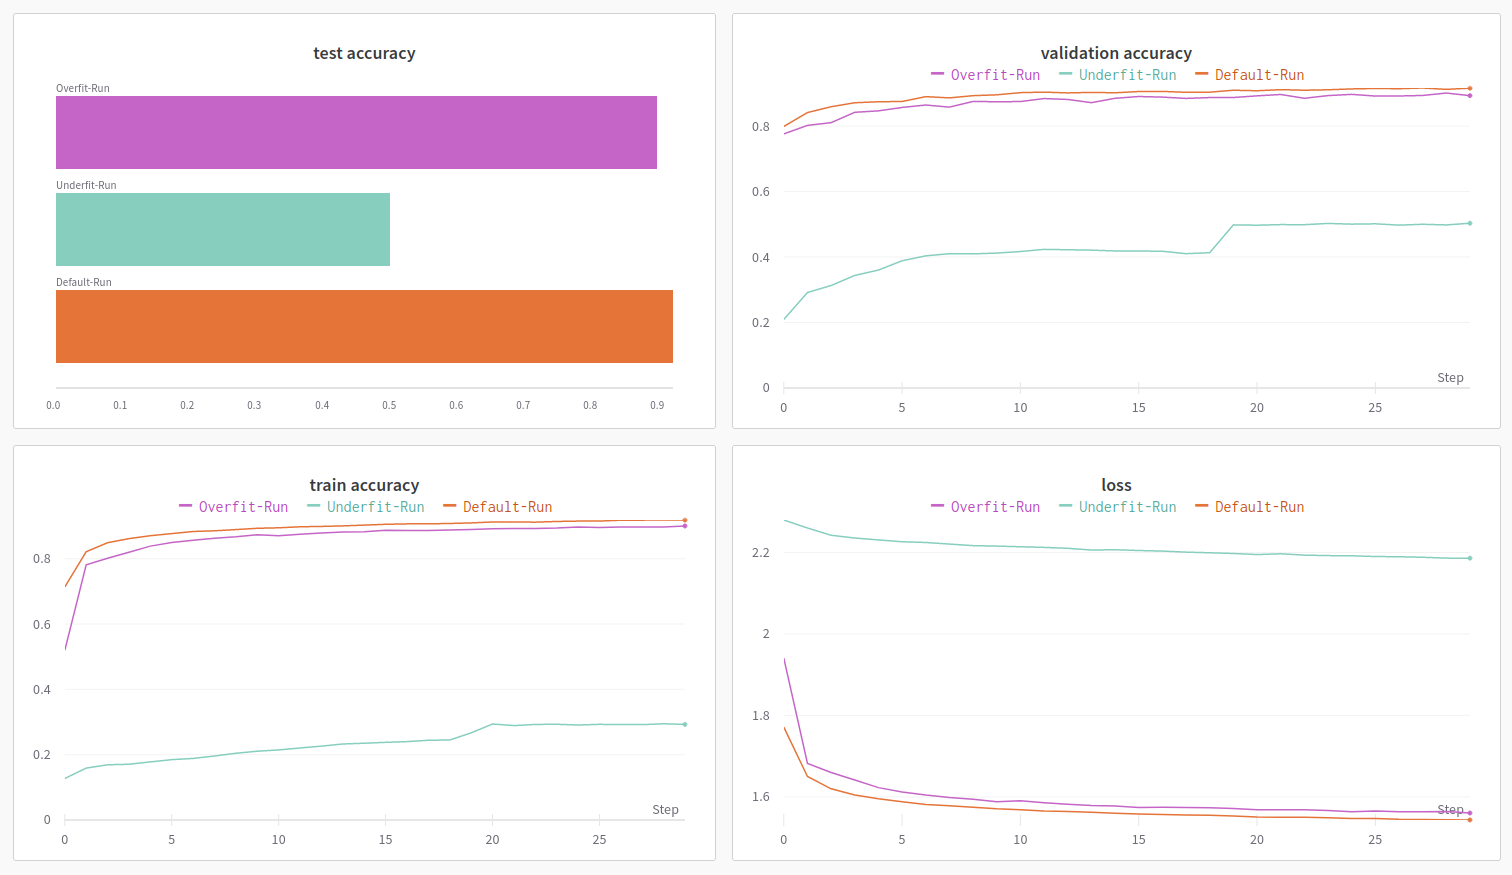

In [24]:
display.Image('Pics/1.1.png')

### Part 1.2 - Hyper-Parameter Tuning

In [ ]:
parameters = Config._get_dict()
parameters = {key: {'value': value} for key, value in parameters.items()}
parameters['LearningRate'] = {
    'distribution': 'uniform',
    'min': 0,
    'max': 0.001
}
parameters['BatchSize'] = {
    'distribution': 'q_log_uniform_values',
    'q': 16,
    'min': 32,
    'max': 256,
}
parameters['ConvDims'] = {
    'values': [
        (32, 64, 128),
        (64, 128, 256),
        (64, 256, 512),
        (32, 128),
        (64, 256),
    ]
}
parameters['ConvKernelSizes'] = {
    'values': [3, 5, 8]
}
parameters['FCDims'] = {
    'values': [
        (512, 128),
        (256, 64),
        (256,)
    ]
}
parameters['ConvDropout'] = {
    'values': [0.15, 0.25, 0.35]
}
parameters['FCDropout'] = {
    'values': [0.4, 0.5, 0.6]
}


sweep_config = {
    'name': 'Major-Random',
    'method': 'random',
    'metric': {
        'name': 'validation accuracy',
        'goal': 'maximize'
    },
    'parameters': parameters
}


sweep_id = wandb.sweep(
    sweep_config,
    entity='indirected-team',
    project='CI_HW3'
)

In [ ]:
wandb.agent(sweep_id, fit, count=100)

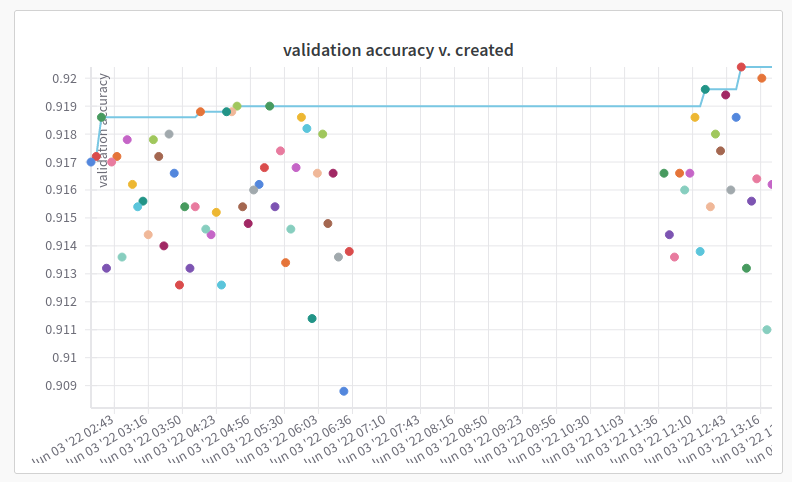

In [26]:
display.Image('Pics/1.2_1.png')

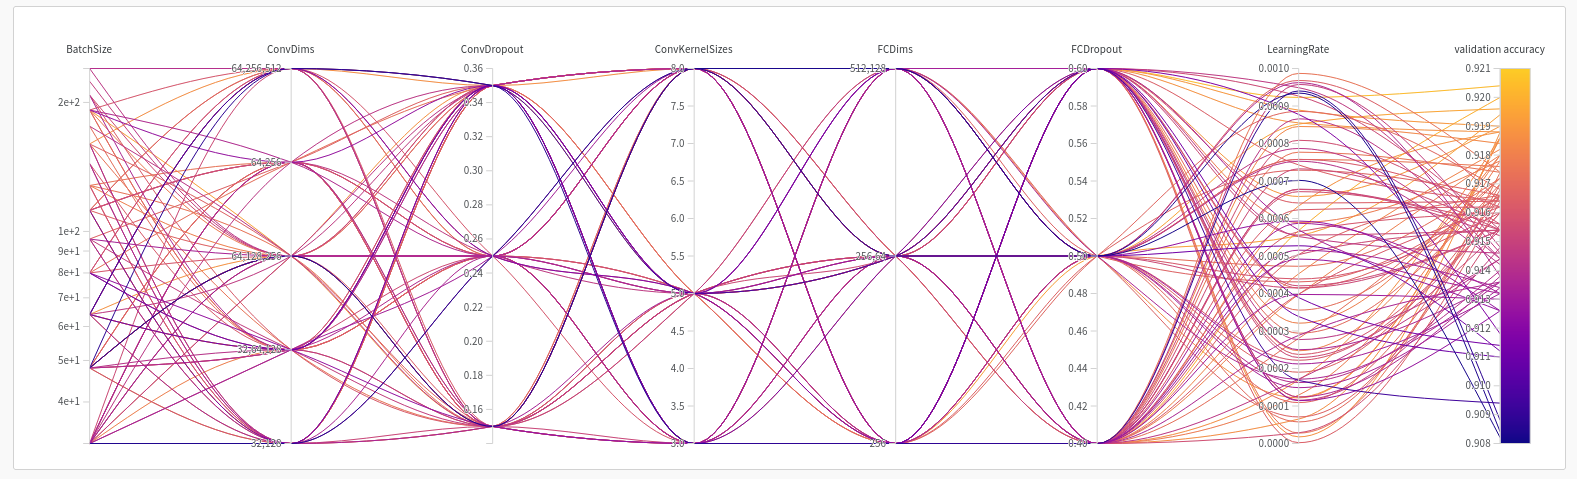

In [25]:
display.Image('Pics/1.2_2.png')

In [21]:
api = wandb.Api()
sweep = api.sweep('indirected-team/CI_HW3/sdk25zhd')
best_run = sweep.best_run()
print(f'Best Hyper-Parameters for Sweep: {sweep.name}:')
print(pd.Series(best_run.config))
print(f'-> Correction! Precise Learning Rate is: {best_run.config["LearningRate"]}')
print('-'*60)
print('Best Model Results:')
pd.Series(dict(best_run.summary))[['loss', 'train accuracy', 'validation accuracy', 'test accuracy']]

Best Hyper-Parameters for Sweep: Major-Random:
Device                  cuda
Epochs                    30
FCDims             [256, 64]
ConvDims           [32, 128]
BatchSize                112
FCDropout                0.6
OutputFile           Log.txt
ConvDropout             0.35
LearningRate        0.000923
ConvKernelSizes            8
PoolKernelSizes            2
dtype: object
-> Correction! Precise Learning Rate is: 0.0009228584061167956
------------------------------------------------------------
Best Model Results:


loss                   1.542345
train accuracy         0.920117
validation accuracy      0.9204
test accuracy            0.9186
dtype: object

## Part 2

### Default Config

In [ ]:
class TransferConfig:
    OutputFile = 'Log.txt'
    Device = 'cuda' if torch.cuda.is_available() else 'cpu'
    LearningRate = 0.0001
    BatchSize = 128
    Epochs = 10
    

    TailFCDims = []
    TailFCDropout = 0.5
    FreezePretrained = False

    @staticmethod
    def _get_dict():
        return {key: value for key, value in TransferConfig.__dict__.items() if not key.startswith('_')}

### Data Preparation

In [ ]:
transform_sequence = transforms.Compose([
    transforms.Resize(56),
    transforms.ToTensor()
])
dataset_train = datasets.FashionMNIST(root='.', download=False, train=True, transform=transform_sequence)
dataset_test = datasets.FashionMNIST(root='.', download=False, train=False, transform=transform_sequence)
dataset_eval, dataset_test = torch.utils.data.random_split(
    dataset=dataset_test,
    lengths=[
        round(len(dataset_test)*0.5),
        round(len(dataset_test)*0.5)
    ],
    generator=torch.Generator().manual_seed(9724133)
)


label_decode = pd.Series({
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
})
image_size = dataset_train[0][0].shape

### Model Definition

In [ ]:
class TimiEfficientB3(nn.Module):
    def __init__(
        self,
        input_shape: typing.Tuple[int],
        num_classes: int,
        freeze_pretrained: bool=False,
        tail_fc_dims: typing.Tuple[int] = tuple(),
        tail_dropout: float = 0.4
    ):
        super().__init__()

        self.tail_dropout = tail_dropout

        self.head = nn.Conv2d(
            in_channels=input_shape[0],
            out_channels=3,
            kernel_size=3,
            padding='same'
        )

        self.eff_b3 = models.efficientnet_b3(pretrained=True)
        if freeze_pretrained:
            for p in self.eff_b3.parameters():
                p.requires_grad = False


        if len(tail_fc_dims) == 0:
            self.tail = nn.ModuleList([
                nn.Linear(
                    in_features=1000,
                    out_features=num_classes
                )
            ])
        else:
            self.tail = nn.ModuleList(
                [
                    nn.Linear(
                        in_features=1000,
                        out_features=tail_fc_dims[0]
                    )
                ] + [
                    nn.Linear(
                        in_features=tail_fc_dims[i],
                        out_features=tail_fc_dims[i+1]
                    )
                    for i in range(len(tail_fc_dims) - 1)
                ] + [
                    nn.Linear(
                        in_features=tail_fc_dims[-1],
                        out_features=num_classes
                    )
                ]
            )
        

    def forward(self, x):
        x = self.head(x)
        x = F.relu(x)

        x = self.eff_b3(x)
        x = F.relu(x)
        F.dropout(x, p=self.tail_dropout, training=self.training)

        for fc in self.tail[:-1]:
            x = fc(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.tail_dropout, training=self.training)
        x = self.tail[-1](x)
        x = F.softmax(x, dim=1)
        return x


### Train / Test Loop

In [ ]:
def train(
    model: nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer
):
    model.train()
    optimizer.zero_grad()
    out = model(X)
    loss = criterion(out, Y)
    loss.backward()
    optimizer.step()

    prediction = torch.argmax(out, dim=1)
    correct = (prediction == Y).sum()
    total = Y.shape[0]
    return loss.item(), correct.item(), total


@torch.no_grad()
def evaluation(
    model: nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor
):
    model.eval()
    out = model(X)
    prediction = torch.argmax(out, dim=1)
    correct = (prediction == Y).sum()
    total = Y.shape[0]
    model.train()
    return correct.item(), total

### Fit and Plot Functions

In [ ]:
def transferfit(config: dict=None, summary: bool=False, nested_tqdm: bool=False, use_wandb: bool=True):
    if config is None:
        config=TransferConfig._get_dict()

    if use_wandb:
        wandb.init(
            project="CI_HW3",
            entity="indirected-team",
            config=config
        )

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=config['BatchSize'], shuffle=True)
    eval_loader = torch.utils.data.DataLoader(dataset_eval, batch_size=config['BatchSize']*2, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=config['BatchSize']*2, shuffle=False)

    model = TimiEfficientB3(
        input_shape=image_size,
        num_classes=label_decode.shape[0],
        freeze_pretrained=config['FreezePretrained'],
        tail_fc_dims=config['TailFCDims'],
        tail_dropout=config['TailFCDropout']
    ).to(config['Device'])

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['LearningRate'])

    with open(config['OutputFile'], 'w') as fp:
        fp.write('')

    if summary:
        print(torchinfo.summary(
            model,
            input_size=(config['BatchSize'], image_size[0], image_size[1], image_size[2]),
            col_names=[
                "input_size",
                "output_size",
                "num_params",
            ]
        ))

    try:
        loss_list = []
        train_acc_list = []
        eval_acc_list = []
        for epoch in tqdm(range(config['Epochs'])):
            train_epoch_loss = 0
            train_epoch_correct = 0
            train_epoch_total = 0
            gen = tqdm(train_loader, leave=False, desc='Train') if nested_tqdm else train_loader

            for batch_x, batch_y in gen:
                batch_x = batch_x.to(config['Device'])
                batch_y = batch_y.to(config['Device'])
                
                train_loss, train_correct, train_total = train(model, batch_x, batch_y, criterion, optimizer)

                train_epoch_loss += train_loss
                train_epoch_correct += train_correct
                train_epoch_total += train_total

            eval_epoch_correct = 0
            eval_epoch_total = 0
            gen = tqdm(eval_loader, leave=False, desc='Validation') if nested_tqdm else eval_loader
            for batch_x, batch_y in gen:
                batch_x = batch_x.to(config['Device'])
                batch_y = batch_y.to(config['Device'])
                eval_correct, eval_total = evaluation(model, batch_x, batch_y)

                eval_epoch_correct += eval_correct
                eval_epoch_total += eval_total

            train_epoch_loss = train_epoch_loss / len(train_loader)
            train_epoch_accuracy = train_epoch_correct / train_epoch_total
            eval_epoch_accuracy = eval_epoch_correct / eval_epoch_total

            loss_list.append(train_epoch_loss)
            train_acc_list.append(train_epoch_accuracy)
            eval_acc_list.append(eval_epoch_accuracy)
            
            if use_wandb:
                wandb.log({
                    'loss': train_epoch_loss,
                    'train accuracy': train_epoch_accuracy,
                    'validation accuracy': eval_epoch_accuracy
                })
            
            with open(config['OutputFile'], 'a') as fp:
                fp.write(f'Epoch: {epoch + 1} - Loss: {train_epoch_loss:.6f} - Train Accuracy: {train_epoch_accuracy*100:.2f} - Validation Accuracy: {eval_epoch_accuracy*100:.2f}\n')
            # print(f'Epoch: {epoch + 1} - Loss: {train_epoch_loss:.6f} - Train Accuracy: {train_epoch_accuracy*100:.2f} - Validation Accuracy: {eval_epoch_accuracy*100:.2f}')
    except KeyboardInterrupt:
        pass


    test_correct = 0
    test_total = 0
    for batch_x, batch_y in tqdm(test_loader, desc='Test'):
        batch_x = batch_x.to(config['Device'])
        batch_y = batch_y.to(config['Device'])
        correct, total = evaluation(model, batch_x, batch_y)

        test_correct += correct
        test_total += total

    test_accuracy = test_correct / test_total
    with open(config['OutputFile'], 'a') as fp:
        fp.write(f'Test Accuracy: {test_accuracy*100:.2f}\n')
    # print(f'Test Accuracy: {test_accuracy*100:.2f}')
    if use_wandb:
        wandb.log({'test accuracy': test_accuracy})
        wandb.finish()
    return loss_list, train_acc_list, eval_acc_list, test_accuracy

In [ ]:
def plots(loss_list, train_acc_list, eval_acc_list, figsize: tuple=(18, 5), saveto: str=None):
    fig, axs = plt.subplots(1, 2, squeeze=False, figsize=figsize)
    axs[0, 0].plot(
        loss_list,
        label='Train Loss'
    )
    axs[0, 0].set_title('Loss Over Epochs')
    axs[0, 0].legend()
    
    axs[0, 1].plot(
        train_acc_list,
        label='Train Accuracy'
    )
    axs[0, 1].plot(
        eval_acc_list,
        label='Validation Accuracy'
    )
    axs[0, 1].legend()
    axs[0, 1].set_title('Accuracy Over Epochs')

    if saveto is not None:
        fig.savefig(saveto, bbox_inches='tight')

### Default Parameters Run

In [ ]:
loss_list, train_acc_list, eval_acc_list, test_accuracy = transferfit(use_wandb=False, summary=False, nested_tqdm=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy: 89.24


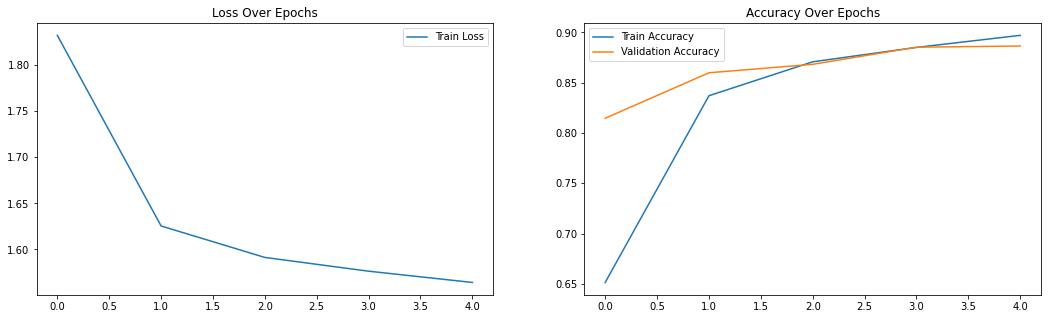

In [ ]:
print(f'Test Accuracy: {test_accuracy*100:.2f}')
plots(loss_list, train_acc_list, eval_acc_list)

### Part 2.1 - Unfreezed Model Hyper-Parameter Tuning

In [ ]:
parameters = TransferConfig._get_dict()
parameters = {key: {'value': value} for key, value in parameters.items()}
parameters['LearningRate'] = {
    'distribution': 'uniform',
    'min': 0,
    'max': 0.001
}
parameters['TailFCDropout'] = {
    'values': [0.3, 0.4, 0.5]
}


sweep_config = {
    'name': 'Unfreezed-TimiEfficientB3',
    'method': 'random',
    'metric': {
        'name': 'validation accuracy',
        'goal': 'maximize'
    },
    'parameters': parameters
}


sweep_id = wandb.sweep(
    sweep_config,
    entity='indirected-team',
    project='CI_HW3'
)

Create sweep with ID: yevc3fmy
Sweep URL: https://wandb.ai/indirected-team/CI_HW3/sweeps/yevc3fmy


In [ ]:
wandb.agent(sweep_id, transferfit, count=5, entity='indirected-team', project='CI_HW3')

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-cf984f9c.pth


  0%|          | 0.00/47.2M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

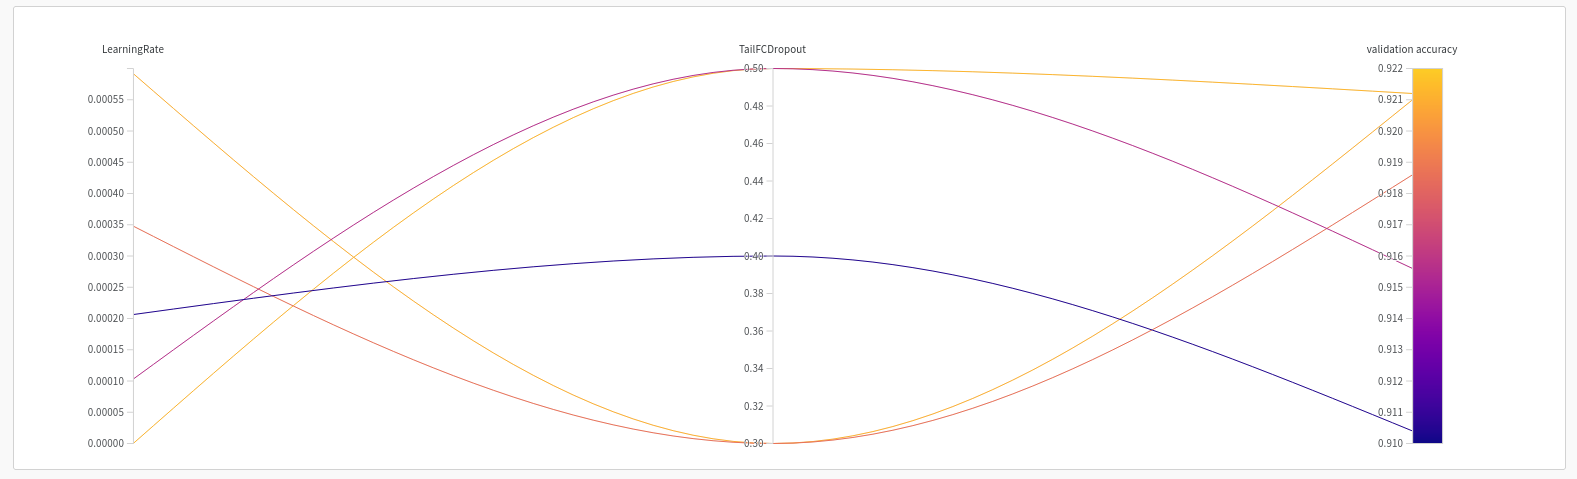

In [27]:
display.Image('Pics/2.1.png')

In [20]:
api = wandb.Api()
sweep = api.sweep('indirected-team/CI_HW3/yevc3fmy')
best_run = sweep.best_run()
print(f'Best Hyper-Parameters for Sweep: {sweep.name}:')
print(pd.Series(best_run.config))
print(f'-> Correction! Precise Learning Rate is: {best_run.config["LearningRate"]}')
print('-'*60)
print('Best Model Results:')
print(pd.Series(dict(best_run.summary))[['loss', 'train accuracy', 'validation accuracy', 'test accuracy']])

Best Hyper-Parameters for Sweep: Unfreezed-TimiEfficientB3:
Device                 cuda
Epochs                   10
BatchSize               128
OutputFile          Log.txt
TailFCDims               []
LearningRate            0.0
TailFCDropout           0.5
FreezePretrained      False
dtype: object
-> Correction! Precise Learning Rate is: 3.340055470282266e-07
------------------------------------------------------------
Best Model Results:
loss                   1.525689
train accuracy         0.935417
validation accuracy      0.9212
test accuracy            0.9256
dtype: object


### Part 2.2 - Freezed Model Hyper-Parameter Tuning

In [ ]:
parameters = TransferConfig._get_dict()
parameters = {key: {'value': value} for key, value in parameters.items()}
parameters['LearningRate'] = {
    'distribution': 'uniform',
    'min': 0,
    'max': 0.001
}
parameters['TailFCDropout'] = {
    'values': [0.3, 0.4, 0.5]
}
parameters['FreezePretrained'] = {'value': True}


sweep_config = {
    'name': 'Freezed-TimiEfficientB3',
    'method': 'random',
    'metric': {
        'name': 'validation accuracy',
        'goal': 'maximize'
    },
    'parameters': parameters
}


sweep_id = wandb.sweep(
    sweep_config,
    entity='indirected-team',
    project='CI_HW3'
)

Create sweep with ID: mwp41aya
Sweep URL: https://wandb.ai/indirected-team/CI_HW3/sweeps/mwp41aya


In [ ]:
wandb.agent(sweep_id, transferfit, count=5, entity='indirected-team', project='CI_HW3')

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

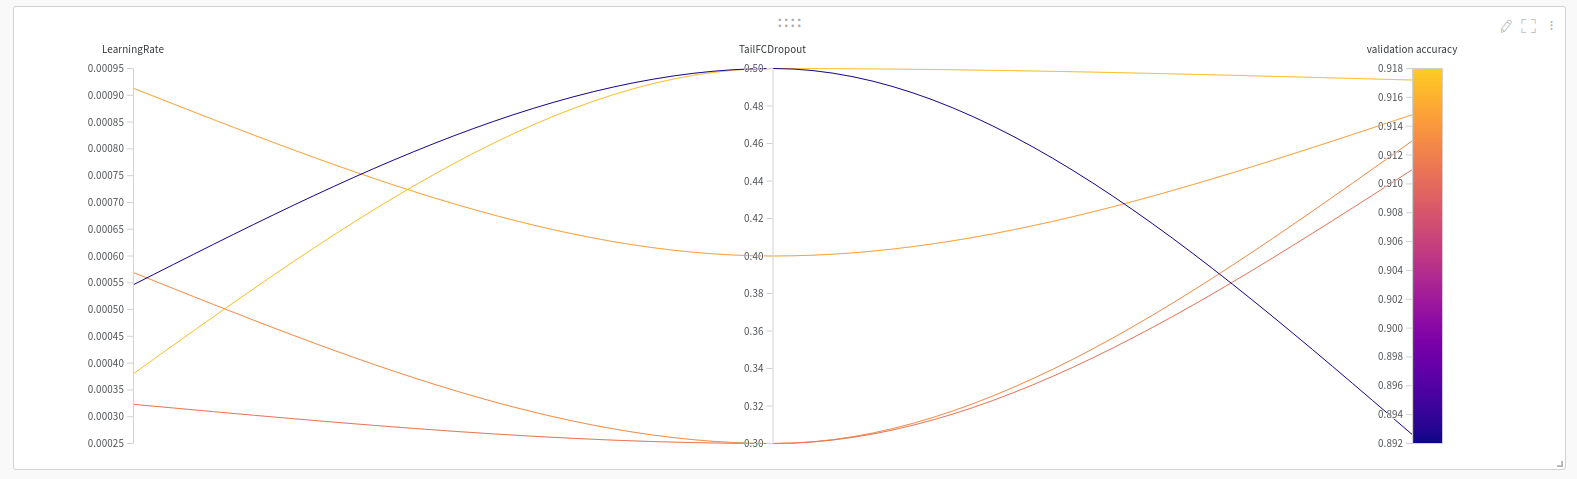

In [28]:
display.Image('Pics/2.2.png')

In [22]:
api = wandb.Api()
sweep = api.sweep('indirected-team/CI_HW3/mwp41aya')
best_run = sweep.best_run()
print(f'Best Hyper-Parameters for Sweep: {sweep.name}:')
print(pd.Series(best_run.config))
print(f'-> Correction! Precise Learning Rate is: {best_run.config["LearningRate"]}')
print('-'*60)
print('Best Model Results:')
print(pd.Series(dict(best_run.summary))[['loss', 'train accuracy', 'validation accuracy', 'test accuracy']])

Best Hyper-Parameters for Sweep: Freezed-TimiEfficientB3:
Device                 cuda
Epochs                   10
BatchSize               128
OutputFile          Log.txt
TailFCDims               []
LearningRate        0.00038
TailFCDropout           0.5
FreezePretrained       True
dtype: object
-> Correction! Precise Learning Rate is: 0.00038025038754586226
------------------------------------------------------------
Best Model Results:
loss                   1.52637
train accuracy         0.93465
validation accuracy     0.9172
test accuracy           0.9238
dtype: object
